In [24]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])

In [3]:
# Check for stationarity

In [4]:
result = adfuller(ts["Adj Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Non-stationary -> need to differentiate

ADF Statistic: -1.522240
p-value: 0.522482


In [5]:
ts["Close_Diff"] = ts["Adj Close"].diff()

In [6]:
result = adfuller(ts["Close_Diff"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Stationary

ADF Statistic: -11.104181
p-value: 0.000000


/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


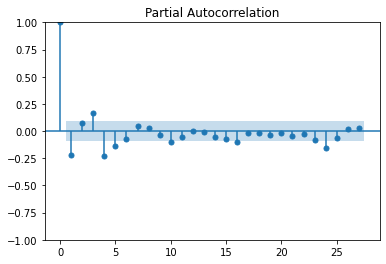

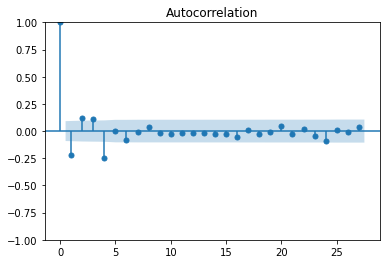

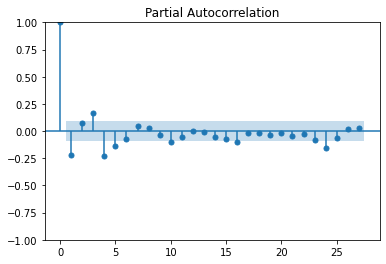

In [7]:
plot_acf(ts.Close_Diff.dropna())
plot_pacf(ts.Close_Diff.dropna())

In [8]:
# Build model and implement rolling window (= ExpandingWindowSplitter) for hyperparameter tuning

In [9]:
# Train, test split
series = ts["Close_Diff"].dropna()
train_size = int(round(len(series) * 0.80, 0))

train = series[:train_size]
y_test = list(series[train_size:])

# Train, val split
train_size2 = int(round(len(train) * 0.80, 0))
y_train = list(train[:train_size2])
y_val = list(train[train_size2:])

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_rolling_forecast(train, val, params):
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order=params)
        model_fit = model.fit(return_params=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = val[t]
        history.append(obs)
        # print("%d/%d predicted=%f, expected=%f" % (t, len(val), yhat, obs))

    # Need to also invert the scale to be on the same scale as LSTMs
    rmse = mean_squared_error(np.array(val).cumsum().astype('float64'), np.array(predictions).cumsum().astype('float64'), squared = False) # If True returns MSE value, if False returns RMSE value.
    mse = mean_squared_error(np.array(val).cumsum().astype('float64'), np.array(predictions).cumsum().astype('float64'), squared = True)
    mae = mean_absolute_error(np.array(val).cumsum().astype('float64'), np.array(predictions).cumsum().astype('float64'))

    return rmse, mse, mae, predictions, val

In [11]:
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

para = [(5,0,0), (1,0,1), (2,0,2), (0,0,5), (1,0,0), (0,0,1), (3, 0, 3)]

In [12]:
history = []
for p in para:
    rmse, mse, mae, _, _ = run_rolling_forecast(y_train, y_val, p)
    s = "Params: " + str(p) + ";RMSE: " + str(rmse) + ";MSE:" + str(mse) + ";MAE:" + str(mae)
    history.append(s)

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [15]:
history

['Params: (5, 0, 0);RMSE: 108.88291058591656;MSE:11855.488217660703;MAE:96.9362507694694',
 'Params: (1, 0, 1);RMSE: 82.48187410268469;MSE:6803.259555491128;MAE:66.89871703045758',
 'Params: (2, 0, 2);RMSE: 51.96460301321425;MSE:2700.3199663209557;MAE:36.50098233352389',
 'Params: (0, 0, 5);RMSE: 128.8774986543363;MSE:16609.409659398458;MAE:117.64592417672579',
 'Params: (1, 0, 0);RMSE: 85.1858270758379;MSE:7256.625134594558;MAE:69.40792961872026',
 'Params: (0, 0, 1);RMSE: 84.32142608015984;MSE:7110.102896191859;MAE:69.09558434298137',
 'Params: (3, 0, 3);RMSE: 62.59831288688932;MSE:3918.548776284893;MAE:49.93003363426454']

In [16]:
# Save parameters to text file
textfile = open("./eval_model/arima_prediction.txt", "w")
for item in history:
    textfile.write(item + "\n")
textfile.close()

In [17]:
# Save parameters to csv
params = []
rmse = []
mse = []
mae = []
for item in history:
    params.append(item.split(";")[0][8:])
for item in history:
    rmse.append(item.split(";")[1][5:])
for item in history:
    mse.append(item.split(";")[2][4:])
for item in history:
    mae.append(item.split(";")[3][4:])

df = pd.DataFrame({
    "Params": [item for item in params],
    "RMSE": [item for item in rmse],
    "MSE": [item for item in mse],
    "MAE": [item for item in mae]
})

df.to_csv("./eval_model/arima_prediction.csv", sep='\t')

In [18]:
# Hypothetically now, select best later on
best_param = (2, 0, 2)

In [19]:
y_train_final = y_train + y_val

In [20]:
rmse, mse, mae, y_pred, test = run_rolling_forecast(y_train_final, y_test, best_param)

In [21]:
# Inverse the difference
def diff_inv(series_diff, first_value):
    series_inverted = list(np.r_[first_value, series_diff].cumsum().astype('float64'))
    return series_inverted

In [22]:
LAST_OBSERVED_VALUE_BEFORE_TEST_SET = ts["Adj Close"][len(y_train_final)]
plt_test = diff_inv(y_test, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_pred = diff_inv(y_pred, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_train = diff_inv(y_train, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)

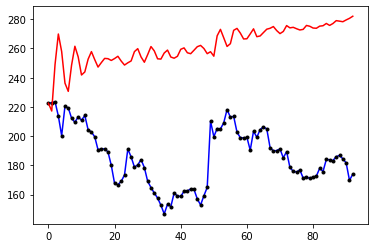

In [27]:
# Plot Price Data
from matplotlib import pyplot
pyplot.plot(ts["Adj Close"].values[len(y_train_final):], '-', color = "blue")
pyplot.plot(plt_test, '.', color = "black")
pyplot.plot(plt_pred, color = "red")
# Can confirm that the correct last observed value was selected

In [28]:
rmse = mean_squared_error(plt_test, plt_pred, squared = False)
mse = mean_squared_error(plt_test, plt_pred, squared = True)
mae = mean_absolute_error(plt_test, plt_pred)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 79.99825848069582
MSE: 6399.721359944221
MAE: 75.96256608776106


In [29]:
len(y_train_final)+len(y_pred)

458

In [30]:
len(y_train_final)

366

In [31]:
testPredictPlot = np.empty_like(ts["Adj Close"])
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_final):] = plt_pred

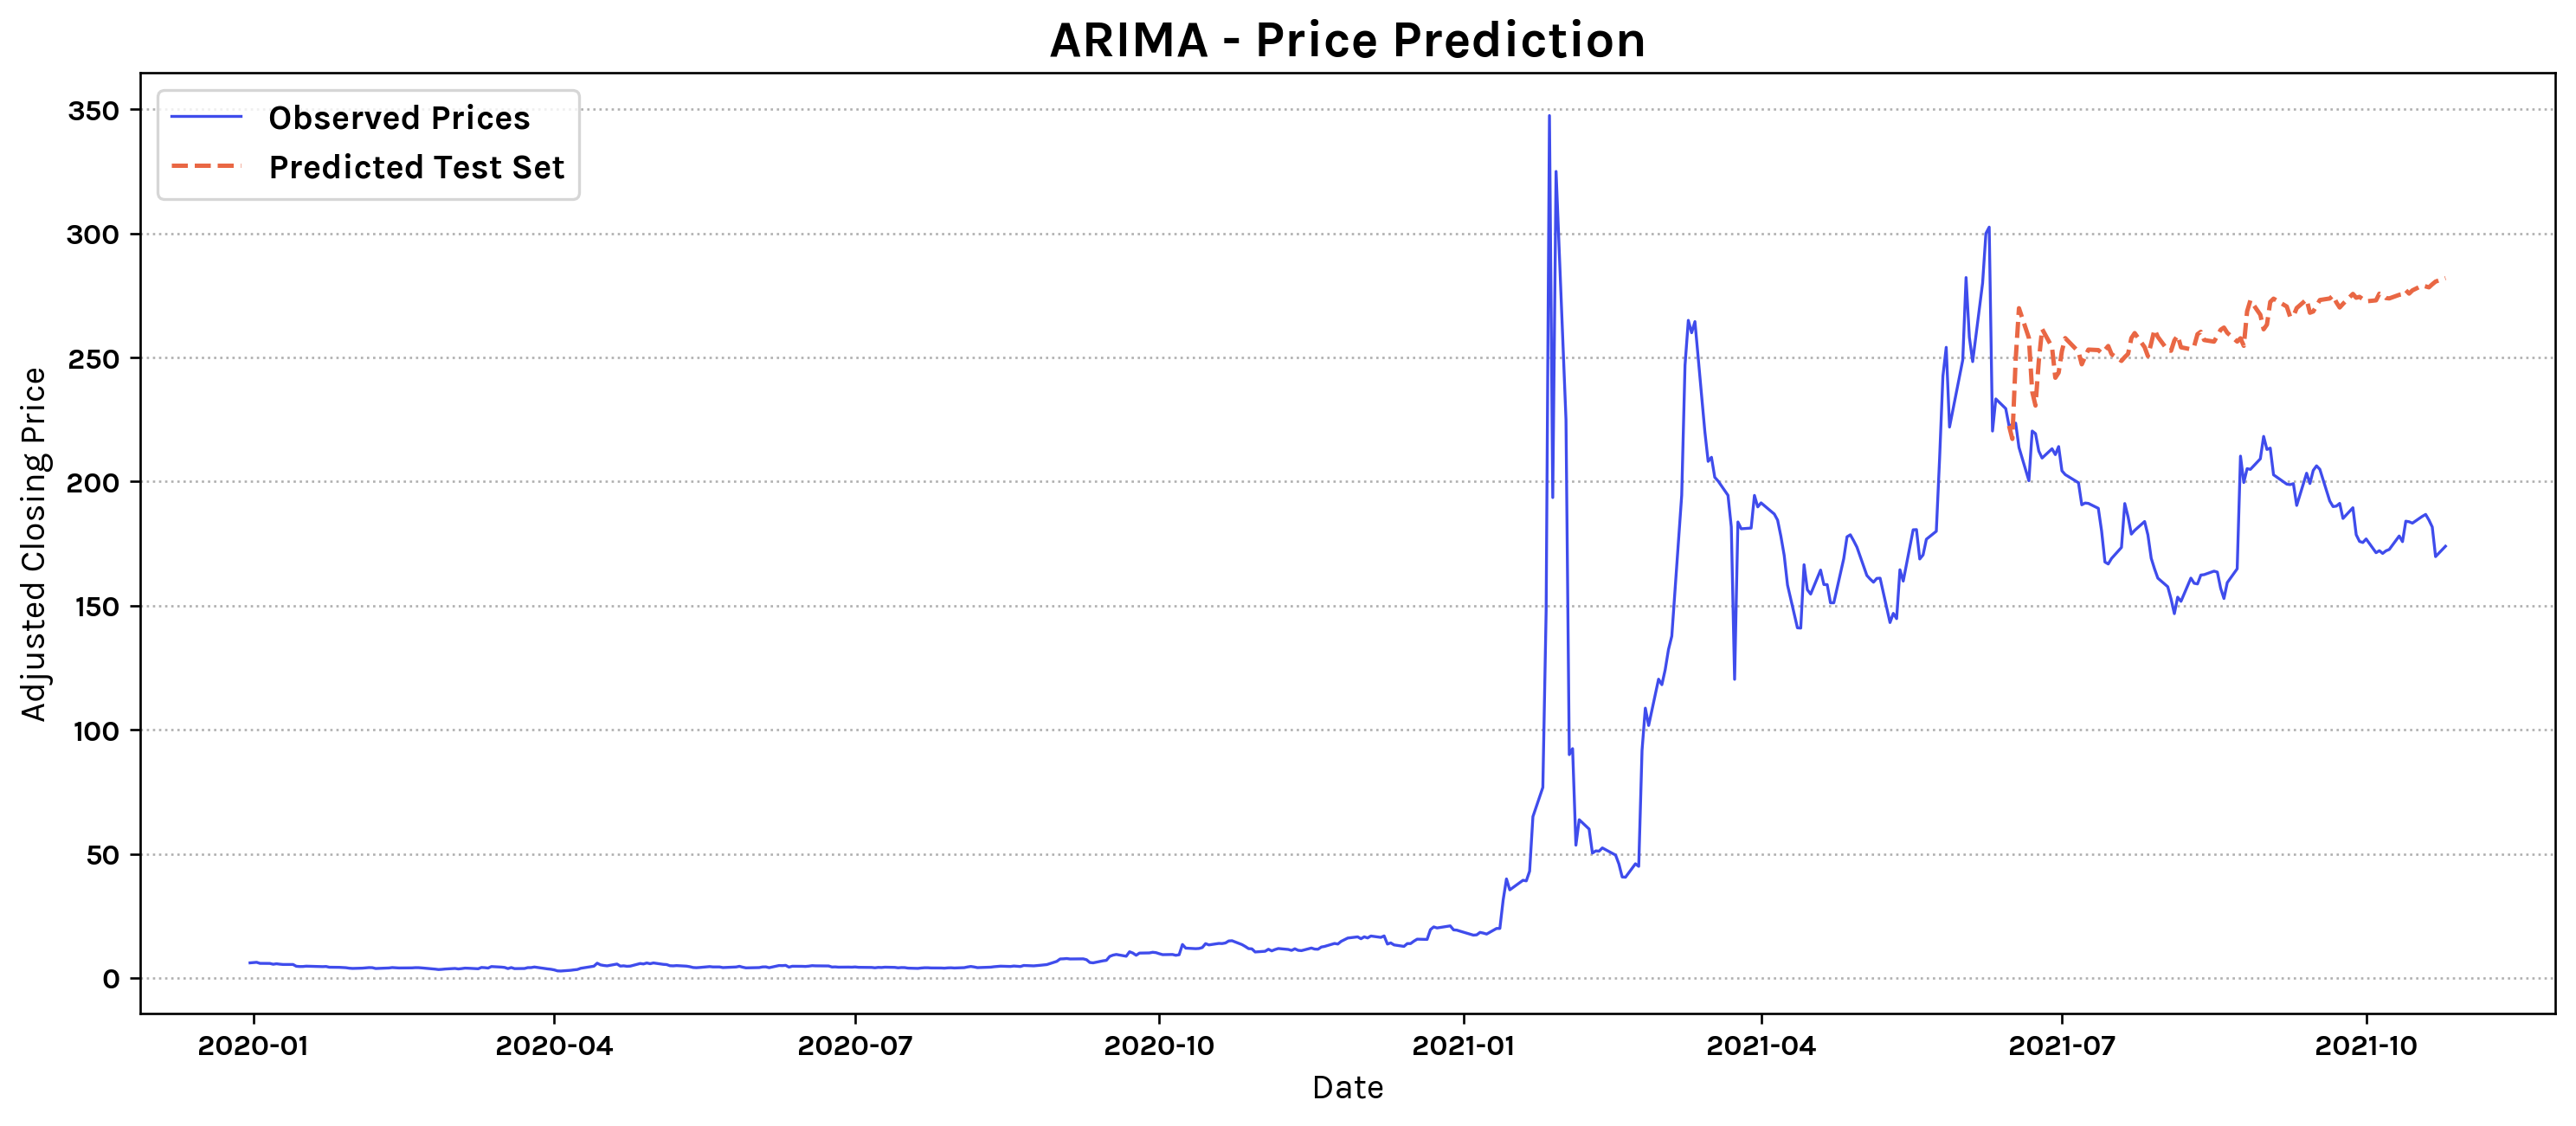

In [32]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

x = ts.Date
plt.plot(x, ts["Adj Close"], color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 12})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("ARIMA - Price Prediction", fontsize = 18, weight = "bold")
plt.show()